# Analysis of CiDiff


## Imports and files

In [1]:
import numpy as np
import pandas as pd
import plotnine as pn
import mizani.transforms as tr

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [24]:
DATASET_FILE = "../build/reports/dataset.csv"
BENCHMARK_FILE = "../build/reports/benchmark-variant.csv"


## Dataset Analysis

In [3]:
dataset = pd.read_csv(DATASET_FILE, sep=',')
dataset["total_size"] = dataset["success"] + dataset["failure"]
dataset.head()

,repository,run,language,success,failure,total_size
0,stimulusreflex/cable_ready,run740-1,Ruby,587,492,1079
1,stimulusreflex/cable_ready,run456-0,Ruby,585,603,1188
2,stimulusreflex/cable_ready,run740-2,Ruby,579,498,1077
3,stimulusreflex/cable_ready,run740-0,Ruby,588,486,1074
4,stimulusreflex/cable_ready,run740-3,Ruby,587,507,1094


In [4]:
len(dataset)

22260

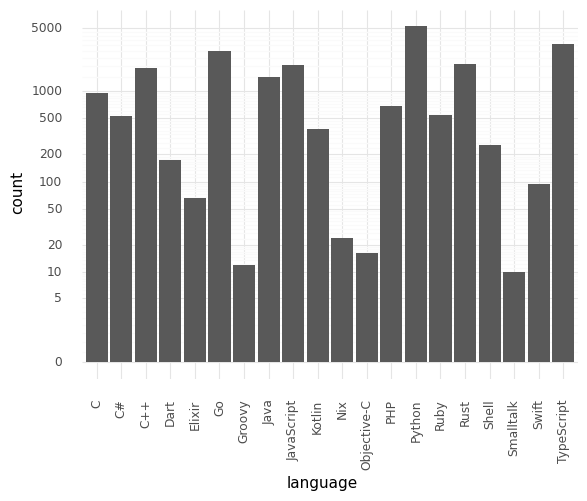

<ggplot: (314187093)>

In [5]:
pn.ggplot(dataset, pn.aes(x="language")) + pn.geom_bar() + pn.theme_minimal() + pn.theme(axis_text_x = pn.element_text(angle = 90)) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20, 50, 100, 200, 500, 1000, 5000])

In [6]:
dataset["language"].value_counts().to_frame()

,language
Python,5211
TypeScript,3355
Go,2773
Rust,1978
JavaScript,1952
C++,1799
Java,1428
C,962
PHP,690
Ruby,543


In [7]:
len(set(dataset["repository"].to_list()))

7984

/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


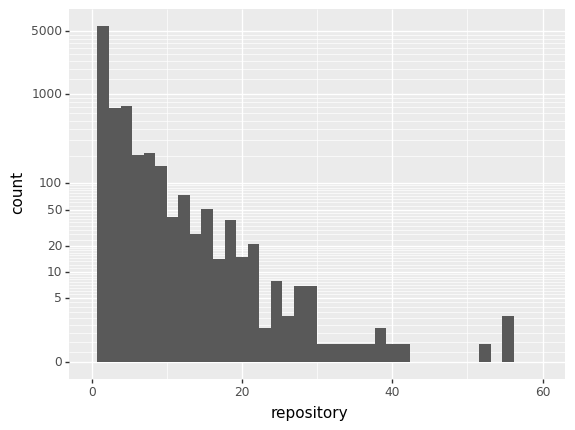

<ggplot: (325900277)>

In [8]:
pn.ggplot(dataset["repository"].value_counts().to_frame(), pn.aes(x="repository")) + pn.geom_histogram(bins=40) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20,50, 100, 1000, 5000]) + pn.xlim(0,60)

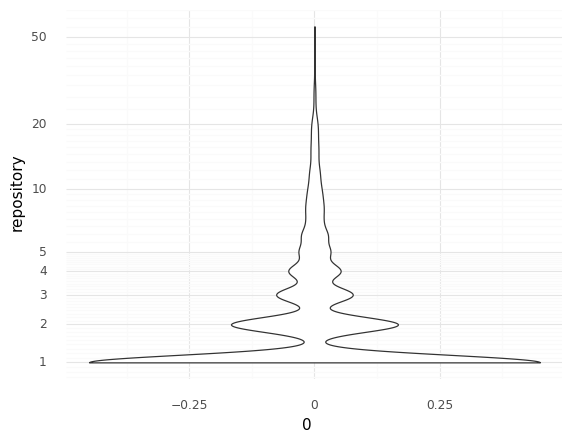

<ggplot: (326015045)>

In [9]:
pn.ggplot(dataset["repository"].value_counts().to_frame(), pn.aes(x=0, y="repository")) + pn.geom_violin() +  pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 1, 2, 3, 4, 5, 10, 20,50, 100, 1000, 5000]) + pn.theme_minimal()

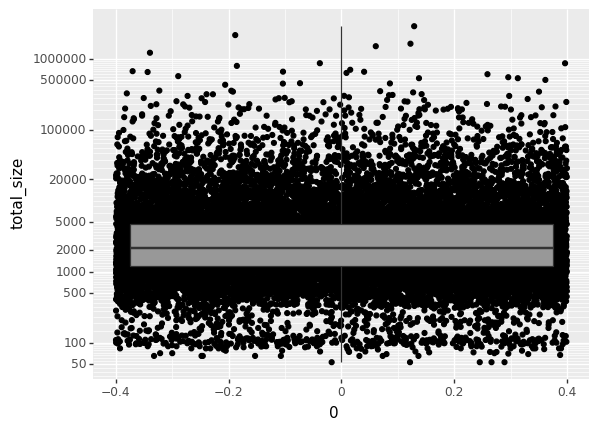

<ggplot: (326132273)>

In [10]:
pn.ggplot(dataset, pn.aes(x=0, y="total_size")) + pn.geom_jitter() + pn.geom_boxplot(coef=1000, alpha=0.6) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 50, 100, 500, 1000, 2000, 5000, 20000, 100000, 500000, 1000000])

/Users/falleri/.pyenv/versions/3.11.2/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 115'. Pick better value with 'binwidth'.


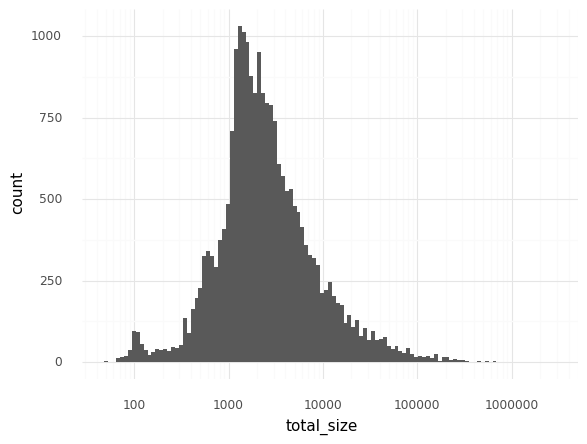

<ggplot: (326506681)>

In [11]:
pn.ggplot(dataset, pn.aes(x="total_size")) + pn.geom_histogram() + pn.scale_x_log10(breaks=[1,10,100,1000,10000,100000,1000000], labels=["1","10","100","1000","10000","100000","1000000"]) + pn.theme_minimal()

## Benchmark Results Analysis

In [96]:
data = pd.read_csv(BENCHMARK_FILE, sep=',')
data["adddel"] = data["added"] + data["deleted"]
data.head()

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,adddel
0,budibase/budibase/run14093-5,unique,18,2625,657,2413,64,2032,317,0,0,79,40,39,2096
1,budibase/budibase/run14093-5,even,6,2625,657,2413,64,2032,317,0,0,79,40,39,2096
2,budibase/budibase/run14093-5,even-recurse,3,2625,657,2413,64,2032,317,0,0,79,40,39,2096
3,budibase/budibase/run14093-5,uneven,3,2625,657,2400,54,2022,317,7,0,121,62,59,2076
4,budibase/budibase/run14093-5,lcs,67,2625,657,2724,378,2346,0,0,0,87,44,43,2724


In [87]:
ref_data = data[data["type"] == "lcs"][["directory", "duration", "actions", "adddel"]]

variant_data = data[~data["type"].isin(["lcs"])]
merged_data = variant_data.merge(ref_data, left_on="directory", right_on="directory", how="left", suffixes=["", "_lcs"])

merged_data["duration_diff"] = 100 * (merged_data["duration_lcs"] - merged_data["duration"] + 1) / (merged_data["duration_lcs"] + 1)
merged_data["actions_diff"] = 100 * (merged_data["actions_lcs"] - merged_data["actions"]) / merged_data["actions"]
merged_data["adddel_diff"] = 100 * (merged_data["adddel_lcs"] - merged_data["adddel"]) / merged_data["adddel"]

merged_data.head()


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration_lcs,actions_lcs,duration_diff,actions_diff
0,budibase/budibase/run14093-5,unique,18,2625,657,2413,64,2032,317,0,0,79,40,39,67,2724,73.529412,12.888521
1,budibase/budibase/run14093-5,even,6,2625,657,2413,64,2032,317,0,0,79,40,39,67,2724,91.176471,12.888521
2,budibase/budibase/run14093-5,even-recurse,3,2625,657,2413,64,2032,317,0,0,79,40,39,67,2724,95.588235,12.888521
3,budibase/budibase/run14093-5,uneven,3,2625,657,2400,54,2022,317,7,0,121,62,59,67,2724,95.588235,13.500000
4,guanguans/notify/run292-0,unique,5,942,870,137,26,98,13,0,0,64,31,33,1,150,-150.000000,9.489051


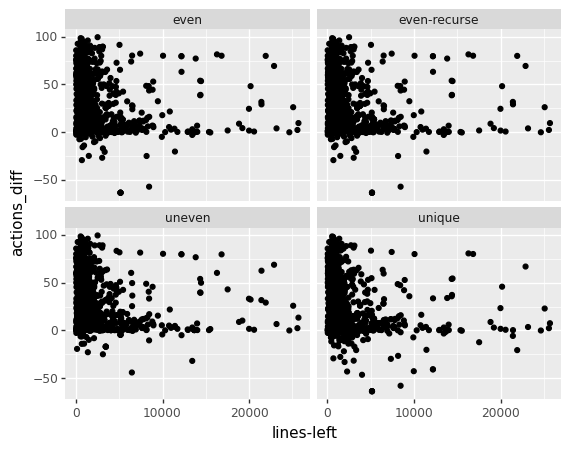

<ggplot: (329326081)>

In [94]:
pn.ggplot(merged_data, pn.aes(x="lines-left", y="actions_diff")) + pn.geom_point() + pn.facet_wrap("type")

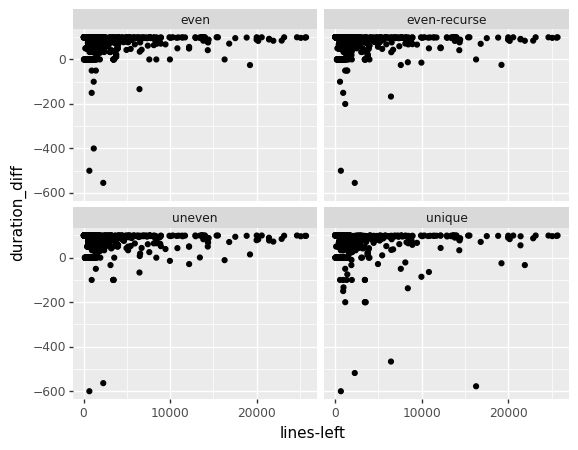

<ggplot: (331313645)>

In [95]:
pn.ggplot(merged_data, pn.aes(x="lines-left", y="duration_diff")) + pn.geom_point() + pn.facet_wrap("type")

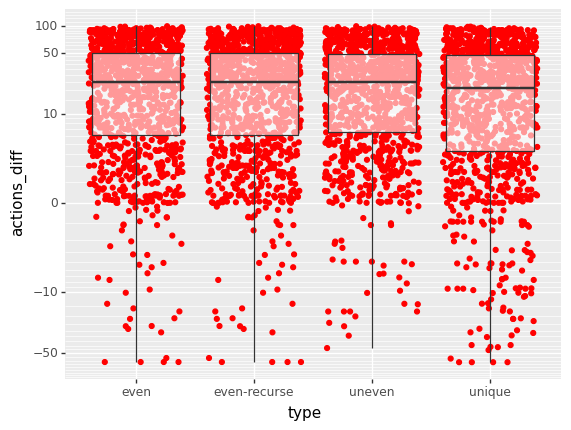

<ggplot: (330539893)>

In [78]:
pn.ggplot(merged_data, pn.aes(x="type", y="actions_diff")) + pn.geom_jitter(color="red") + pn.geom_boxplot(coef=1000000, alpha=0.6) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks = [-100, -50, -10, 0, 10, 50, 100, 200, 500, 1000, 10000])

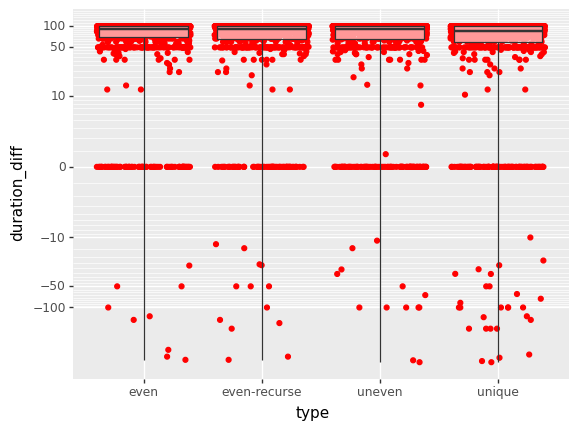

<ggplot: (330503545)>

In [89]:
pn.ggplot(merged_data, pn.aes(x="type", y="duration_diff")) + pn.geom_jitter(color="red") + pn.geom_boxplot(coef=1000000, alpha=0.6) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks = [-100, -50, -10, 0, 10, 50, 100, 200, 500, 1000, 10000])

In [88]:
merged_data[merged_data["type"] == "uneven"][merged_data["actions_diff"] < 0]

/var/folders/kk/cgjmm8nx2cq30pc0gryphmjm0000gn/T/ipykernel_95171/2906647399.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration_lcs,actions_lcs,duration_diff,actions_diff
7,guanguans/notify/run292-0,uneven,2,942,870,174,25,97,11,41,0,217,109,108,1,150,0.000000,-13.793103
159,grpc/grpc-kotlin/run624-0,uneven,2,1379,992,770,44,431,39,256,0,1071,537,534,2,595,33.333333,-22.727273
375,ipython/traitlets/run1310-12,uneven,0,133,134,26,6,5,5,10,0,83,41,42,0,21,100.000000,-19.230769
415,appium/appium-uiautomator2-server/run127-1,uneven,2,1490,1561,706,260,189,59,197,1,768,398,370,2,637,33.333333,-9.773371
579,beast-dev/beast-mcmc/run966-0,uneven,348,13433,8399,11191,613,5647,342,4366,223,4867,3189,1678,350,7634,0.854701,-31.784470
731,dungeon-revealer/dungeon-revealer/run18948-1,uneven,0,687,618,176,40,109,7,20,0,126,72,54,1,165,100.000000,-6.250000
971,schemahero/schemahero/run1583-0,uneven,2,1202,1060,614,116,258,65,159,16,723,370,353,2,572,33.333333,-6.840391
978,duartegroup/autode/run867-0,uneven,5,5149,5203,1293,467,413,158,254,1,1580,791,789,8,1236,44.444444,-4.408353
979,duartegroup/autode/run867-0,uneven,5,5149,5203,1293,467,413,158,254,1,1580,791,789,9,1236,50.000000,-4.408353
1007,nextcloud/notifications/run685-0,uneven,0,51,55,39,19,15,1,4,0,34,18,16,0,38,100.000000,-2.564103
